# Load Image and capture the position of the pixels through clicking.

## 读取图片到笔记本
用PIL.Image、正则表达式re模块 和 globbing模块

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import glob
import time
import itertools
import matplotlib
matplotlib.use('TkAgg')   # 允许GUI式matplotlib，即有弹窗. it must be set before import pyplot
import matplotlib.pyplot as plt

## 一、预处理工作

### 数据文件夹的选取
- 输入数据总文件夹路径
- 如果有不需要处理的文件夹，需重命名为："-"+原名称


实验数据的文件结构规定为：
```
- data  
    |  
    -420v5  
        |  
        -***.hsv  
        -*.  
    -420v10q2  
    -600v1000q6  
    -etc.  
```
需要忽略的experiment级文件名前加"-"  

#### 输入文件夹路径

In [2]:
PATH = r"E:\zhouhan"

#### 查看文件夹列表，看是否有需要忽略的数据，并利用 ignore 和deignore函数进行更改

- 如果有不需要处理的文件夹，在ignore_dir和deignore_dir函数中输入文件夹对应序号，将会将该文件夹重命名为："-"+原名称
- 如果没有，请跳过此步骤

In [5]:
# ********************************
# DO NOT CHANGE ANYTHING BELOW !!!
# ********************************
assert os.path.exists(PATH)  # 必须填入有效的起始文件夹data的绝对路径名称
items = os.listdir(PATH)  # PATH下的所有item
dirs = [item for item in items if os.path.isdir(os.path.join(PATH, item))] # 所有item中的所有文件夹
print("------list of directories------")
for i,j  in enumerate(dirs):
    print(str(i).rjust(2) + ":" + str(j).rjust(12))

def ignore_dir(index, lst=dirs):
    if index==-1:
        return None
    elif index < len(lst) and lst[index][0] != '-' :  # 已经忽略的不重复忽略
        os.rename(PATH+"\\"+lst[index], PATH+"\\-"+lst[index])  
    return None

def deignore_dir(index, lst=dirs):
    if index==-1:
        return None
    elif index < len(lst) and lst[index][0] == '-':  # 已经未忽略的不重复未忽略
        os.rename(PATH+"\\"+lst[index], PATH+"\\"+lst[index][1:])
    return None

AssertionError: 

#### 依据需要选取需要处理（即不需要忽略）的数据

In [7]:
ignore_dir(-1)
deignore_dir(-1)

### 获取目录和子目录
初始化目录和子目录并获取文件夹名

- 初始化文件夹
    - 统一成大写
    - \* 提取信息（流量、转速、粘度）
    - 记录文件夹名列表到dirs变量
- 根据HSV文件数量批量新建子文件，后手动将HSV文件另存为jpeg图片文件到对应文件夹中
    - 记录文件名对应子文件列表的词典到subdirs变量

In [8]:
# ********************************
# DO NOT CHANGE ANYTHING BELOW !!!
# ********************************

### 获取目录和子目录（如果没有则根据目录中的*.HSV文件数量批量创建子文件夹）

items = os.listdir(PATH)  # PATH下的所有item
dirs = [item for item in items if os.path.isdir(os.path.join(PATH, item))] # 所有item中的所有文件夹
dirs = [dir for dir in dirs if not dir[0]=="-"]  # 忽略不处理的数据文件夹（需要忽略的实验文件名前加"-"）

# 改名，将所有experiments级文件夹名由小写改为大写并重新获取目录
for dir in dirs:
    if dir.islower():
        os.rename(PATH+"\\"+dir, PATH+"\\"+dir.upper())

items = os.listdir(PATH)  # PATH下的所有item
dirs = [item for item in items if os.path.isdir(os.path.join(PATH, item))] # 所有item中的所有文件夹
dirs = [dir for dir in dirs if not dir[0]=="-"]  # 忽略不处理的数据文件夹（需要忽略的实验文件前加"-"）
print("***文件名标准化完成***")

# 如果没有创建 子文件夹 的话，按照.hsv文件的名称创建，并以列表的字典形式{dir: list_subdir}记录所有subdirs
subdirs = {}
for dir in dirs:
    list_hsv = glob.glob(PATH+'\\'+dir+'\\*.hsv') # 列出该文件夹下所有hsv文件的路径
    list_subdir = [s.split('.')[0].split("\\")[-1] for s in list_hsv] # 列出该文件夹下所有hsv文件的名字，注意，不包括后缀.hsv
    subdirs[dir] = list_subdir  # 更新subdirs词典

    # 逐文件夹新建和.hsv文件同名的子文件夹
    for subdir in list_subdir:
        if not os.path.exists(PATH+"\\"+dir+"\\"+subdir):
            os.mkdir(PATH+"\\"+dir+"\\"+subdir) 

print("***子文件夹创建完成***")
print("***目录和子目录名称已获取完成***")
print("------list of directories------")
for i,j  in enumerate(dirs):
    print(str(i).rjust(2) + ":" + str(j).rjust(12))

***文件名标准化完成***
***子文件夹创建完成***
***目录和子目录名称已获取完成***
------list of directories------
 0:   420V100Q4
 1:    420V10Q2
 2:   420V20Q02
 3:       420V5
 4:  600V1000Q6
 5:  600V350 Q4
 6:   600V500Q4


## 统计数密度分布函数

### 读取图片
用PIL.Image模块按照PATH+dir+subdir路径遍历读取图片
### 读取坐标
用ginput读取图片中的坐标值
### 储存坐标值并规范化
每张图片储存后，检查坐标值的有效性：
- 如果不规范，重新标注：
- 如果规范，将数据进行存储

In [9]:
# ********************************
# DO NOT CHANGE ANYTHING BELOW !!!
# ********************************
def isvalid(pts):
    # 如果pts是空的
    if len(pts) == 0:
        return False
    # 如果不满足 正好4个一组
    if np.mod(len(pts), 4) != 0:
        return False
    # 如果每组四个点两两之间的距离过大（大于250）
    for start, stop in zip(range(0, len(pts)-1, 4), range(4, len(pts)+1, 4)): 
        for a, b in itertools.combinations(pts[start: stop], 2): 
            if (abs(a[0] - b[0]) > 250 or abs(a[1] - b[1]) > 250):
                return False
    if False:# 如果没有按照对角线顺序选取
        return False
#     if s=input("Sure to sumbit?") # 用户确认功能
    else:
        return True

#iimg 为图片的编号，如果你想从0005号图片开始标注，请输入4，可以理解为跳过前4张图片
def load_image_path(idir, isubdir, iimg=0, stop=3767, step = 1, sample = None):
    img_paths = glob.glob(PATH+"\\"+dirs[idir]+"\\"+subdirs[dirs[idir]][isubdir]+"\\*.jpg")
    # 如果输入参数没有什么错误，就进行切片
    if ((idir in range(len(dirs))) 
        and (isubdir in range(len(subdirs[dirs[idir]]))) 
        and (iimg not in range(3767))
        and (stop not in range(3767))):
        print("Invalid input: \n(index of image must range between 0 - 3766)\n")
        return
    img_paths = img_paths[iimg:stop:step]
    if img_paths == []:
        return
    
    print("开始标注%s中的图片" % dirs[idir]+subdirs[dirs[idir]][isubdir])
    
    if(os.path.exists(os.getcwd()+"\\data_" + str(subdirs[dirs[idir]][isubdir]) + ".csv")):
#         new_data = input("There already exists data.csv, want to cover it with a new one? [Y/N]\n").upper()
#         if new_data =='Y':
#             os.remove(os.getcwd()+"\\data_" + str(subdirs[dirs[idir]][isubdir]) + ".csv")
        print("Note that there already exist data, please check whether to remove")
    
    for img_index, img_path in zip(range(iimg,stop,step), img_paths):
        name_experiment = img_path.split(".")[0].split("\\")[-1].split("_")[0]
        name_pic = img_path.split(".")[0].split(" / ")[-1].split("_")[-1]
        print("正在标注%s:" % name_pic)
        im = Image.open(img_path)
        plt.imshow(im)
        grid_X,grid_Y =  zip(*[(200,100),(200,600), (200,100),(1000,100),
                               (200,350),(1000,350),(400,100),(400,600),
                               (600,100),(600,600), (800,100),(800,600)])
        for n_grid in range(min(len(grid_X),len(grid_Y)) // 2):
            plt.plot(grid_X[2*n_grid: 2*n_grid+2], grid_Y[2*n_grid: 2*n_grid+2],'k--',lw=1)
        grid_X,grid_Y =  zip(*[(1000,100),(1000,600),(200,600),(1000,600)])
        for n_grid in range(min(len(grid_X),len(grid_Y)) // 2):
            plt.plot(grid_X[2*n_grid: 2*n_grid+2], grid_Y[2*n_grid: 2*n_grid+2],'k-',lw=1)
        
        plt.title(name_experiment + ": " + str(idir) + " / " + str(isubdir) + " / " + name_pic)

        pts = []
#         plt.text(10, 10, "Notes: must pick points in diagonal order, or will not pass the test and redo")
        pts = plt.ginput(n=-1, timeout=0, show_clicks=True)

        
        # 如果数据不合格就重新标注一遍
        if not isvalid(pts):
            print("重新标注%s" % name_pic)
            pts = []
            load_image_path(idir, isubdir, iimg=img_index, stop=img_index+1)
            continue
        
        print("完成标注 %s:" %name_pic)
        
        # 保存数据
        n_circle = int(len(pts)/4)
        circle = []
        for i in range(n_circle):
            circle += [i] * 4
        df_circle = pd.DataFrame(circle, columns=['circle'])
        df_dir = pd.DataFrame({'dir':[dirs[idir]]*len(pts),
                               'subdir': [subdirs[dirs[idir]][isubdir]]*len(pts), 
                               "timestamp":[time.asctime()]*len(pts),
                               "pic":name_pic})
        df_pts = pd.DataFrame(pts, columns=list("xy"), copy=True)
        df_data = pd.concat([df_pts, df_circle,df_dir], axis=1)
        print(df_data)
        # if os.getcwd()+
        df_data.to_csv(os.getcwd()+"\\data_" + str(subdirs[dirs[idir]][isubdir]) + ".csv",mode='a', header=False)
        print("数据保存完毕")
    print("所有数据保存完毕，程序退出")
    plt.close()
    return None

In [ ]:
load_image_path(5, 0, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q401
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   364.013494   56.353184       0  600V350 Q4  0001  600V350Q401   
1   374.312984  156.773210       0  600V350 Q4  0001  600V350Q401   
2   419.373252   96.263707       0  600V350 Q4  0001  600V350Q401   
3   318.953226  114.287814       0  600V350 Q4  0001  600V350Q401   
4   249.431669  106.563197       1  600V350 Q4  0001  600V350Q401   
5   249.431669  137.461667       1  600V350 Q4  0001  600V350Q401   
6   232.694998  120.724996       1  600V350 Q4  0001  600V350Q401   
7   268.743213  123.299868       1  600V350 Q4  0001  600V350Q401   
8   240.419616  270.067598       2  600V350 Q4  0001  600V350Q401   
9   233.982435  340.876591       2  600V350 Q4  0001  600V350Q401   
10  199.221656  303.540940       2  600V350 Q4  0001  600V350Q401   
11  276.467830  307.403249       2  600V350 Q4  0001  600V350Q401   
12  343.414514  392.374040       3  600V350 Q4  0001

In [8]:
load_image_path(5, 0, iimg=900,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q401
Note that there already exist data, please check whether to remove
正在标注0901:
完成标注 0901:
             x           y  circle         dir   pic       subdir  \
0   657.548955  168.360136       0  600V350 Q4  0901  600V350Q401   
1   584.165090  200.546042       0  600V350 Q4  0901  600V350Q401   
2   590.602271  155.485774       0  600V350 Q4  0901  600V350Q401   
3   647.249465  215.995277       0  600V350 Q4  0901  600V350Q401   
4   624.075613  132.311922       1  600V350 Q4  0901  600V350Q401   
5   626.650485  159.348083       1  600V350 Q4  0901  600V350Q401   
6   609.913814  145.186284       1  600V350 Q4  0901  600V350Q401   
7   638.237411  145.186284       1  600V350 Q4  0901  600V350Q401   
8   759.256417  222.432458       2  600V350 Q4  0901  600V350Q401   
9   761.831290  259.768109       2  600V350 Q4  0901  600V350Q401   
10  743.807182  241.744001       2  600V350 Q4  0901  600V350Q401   
11  779.855397  240.456565       2  600V350 Q4  0901  

In [9]:
load_image_path(5, 1, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q402
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   501.769171  147.761156       0  600V350 Q4  0001  600V350Q402   
1   510.781224  213.420404       0  600V350 Q4  0001  600V350Q402   
2   536.529949  177.372190       0  600V350 Q4  0001  600V350Q402   
3   473.445574  182.521935       0  600V350 Q4  0001  600V350Q402   
4   446.409413  321.565048       1  600V350 Q4  0001  600V350Q402   
5   443.834540  355.038390       1  600V350 Q4  0001  600V350Q402   
6   461.858648  337.014282       1  600V350 Q4  0001  600V350Q402   
7   425.810433  338.301719       1  600V350 Q4  0001  600V350Q402   
8   518.505842  550.728697       2  600V350 Q4  0001  600V350Q402   
9   477.307882  602.226146       2  600V350 Q4  0001  600V350Q402   
10  527.517895  602.226146       2  600V350 Q4  0001  600V350Q402   
11  467.008392  553.303569       2  600V350 Q4  0001  600V350Q402   
12  672.998190  271.355035       3  600V350 Q4  0001

In [10]:
load_image_path(5, 2, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q403
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   294.491937  209.558096       0  600V350 Q4  0001  600V350Q403   
1   315.090917  142.611412       0  600V350 Q4  0001  600V350Q403   
2   267.455777  163.210391       0  600V350 Q4  0001  600V350Q403   
3   338.264769  194.108861       0  600V350 Q4  0001  600V350Q403   
4   536.529949  526.267409       1  600V350 Q4  0001  600V350Q403   
5   548.116875  590.639220       1  600V350 Q4  0001  600V350Q403   
6   580.302781  557.165878       1  600V350 Q4  0001  600V350Q403   
7   497.906862  566.177932       1  600V350 Q4  0001  600V350Q403   
8   889.287476  358.900698       2  600V350 Q4  0001  600V350Q403   
9   930.485436  307.403249       2  600V350 Q4  0001  600V350Q403   
10  882.850295  316.415303       2  600V350 Q4  0001  600V350Q403   
11  933.060308  351.176081       2  600V350 Q4  0001  600V350Q403   
12  842.939772  167.072700       3  600V350 Q4  0001

In [11]:
load_image_path(5, 3, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q404
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    602.189197  150.336029       0  600V350 Q4  0001  600V350Q404   
1    600.901761  110.425506       0  600V350 Q4  0001  600V350Q404   
2    581.590217  128.449613       0  600V350 Q4  0001  600V350Q404   
3    625.363049  129.737049       0  600V350 Q4  0001  600V350Q404   
4    540.392258  187.671680       1  600V350 Q4  0001  600V350Q404   
5    539.104821  149.048593       1  600V350 Q4  0001  600V350Q404   
6    522.368150  168.360136       1  600V350 Q4  0001  600V350Q404   
7    554.554056  167.072700       1  600V350 Q4  0001  600V350Q404   
8    875.125678  192.821425       2  600V350 Q4  0001  600V350Q404   
9    876.413114  151.623465       2  600V350 Q4  0001  600V350Q404   
10   853.239262  169.647572       2  600V350 Q4  0001  600V350Q404   
11   895.724658  169.647572       2  600V350 Q4  0001  600V350Q404   
12   915.036201  142.611412       3  60

In [9]:
load_image_path(5, 4, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q405
正在标注0001:
重新标注0001
开始标注600V350 Q4中的图片600V350Q405
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    334.402461  167.072700       0  600V350 Q4  0001  600V350Q405   
1    286.767320  107.850633       0  600V350 Q4  0001  600V350Q405   
2    343.414514  110.425506       0  600V350 Q4  0001  600V350Q405   
3    273.892958  152.910901       0  600V350 Q4  0001  600V350Q405   
4    535.242513  136.174230       1  600V350 Q4  0001  600V350Q405   
5    544.254566   78.239600       1  600V350 Q4  0001  600V350Q405   
6    508.206352  105.275761       1  600V350 Q4  0001  600V350Q405   
7    568.715855  111.712942       1  600V350 Q4  0001  600V350Q405   
8    518.505842  179.947062       2  600V350 Q4  0001  600V350Q405   
9    518.505842  154.198338       2  600V350 Q4  0001  600V350Q405   
10   506.918916  163.210391       2  600V350 Q4  0001  600V350Q405   
11   526.230459  167.072700       2  600V350 Q4  0001  600V3

In [8]:
load_image_path(5, 5, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q406
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    380.750165  311.265558       0  600V350 Q4  0001  600V350Q406   
1    407.786326  270.067598       0  600V350 Q4  0001  600V350Q406   
2    364.013494  275.217343       0  600V350 Q4  0001  600V350Q406   
3    423.235561  308.690685       0  600V350 Q4  0001  600V350Q406   
4    282.905011  515.967919       1  600V350 Q4  0001  600V350Q406   
5    245.569361  539.141771       1  600V350 Q4  0001  600V350Q406   
6    246.856797  509.530738       1  600V350 Q4  0001  600V350Q406   
7    280.330139  549.441261       1  600V350 Q4  0001  600V350Q406   
8    647.249465  421.985074       2  600V350 Q4  0001  600V350Q406   
9    680.722807  371.775061       2  600V350 Q4  0001  600V350Q406   
10   627.937921  380.787114       2  600V350 Q4  0001  600V350Q406   
11   688.447424  414.260456       2  600V350 Q4  0001  600V350Q406   
12   858.389007  337.014282       3  60

In [10]:
load_image_path(5, 6, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q407
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   519.793278  263.630417       0  600V350 Q4  0001  600V350Q407   
1   521.080714  234.019384       0  600V350 Q4  0001  600V350Q407   
2   503.056607  249.468619       0  600V350 Q4  0001  600V350Q407   
3   535.242513  249.468619       0  600V350 Q4  0001  600V350Q407   
4   490.182245  197.971169       1  600V350 Q4  0001  600V350Q407   
5   488.894808  181.234498       1  600V350 Q4  0001  600V350Q407   
6   482.457627  187.671680       1  600V350 Q4  0001  600V350Q407   
7   495.331990  187.671680       1  600V350 Q4  0001  600V350Q407   
8   671.710753  307.403249       2  600V350 Q4  0001  600V350Q407   
9   657.548955  249.468619       2  600V350 Q4  0001  600V350Q407   
10  636.949975  280.367088       2  600V350 Q4  0001  600V350Q407   
11  692.309733  273.929907       2  600V350 Q4  0001  600V350Q407   
12  855.814134  427.134819       3  600V350 Q4  0001

In [11]:
load_image_path(5, 7, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q408
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   531.380204  373.062497       0  600V350 Q4  0001  600V350Q408   
1   554.554056  311.265558       0  600V350 Q4  0001  600V350Q408   
2   508.206352  326.714793       0  600V350 Q4  0001  600V350Q408   
3   581.590217  360.188135       0  600V350 Q4  0001  600V350Q408   
4   259.731159  213.420404       1  600V350 Q4  0001  600V350Q408   
5   241.707052  185.096807       1  600V350 Q4  0001  600V350Q408   
6   235.269871  204.408351       1  600V350 Q4  0001  600V350Q408   
7   263.593468  186.384243       1  600V350 Q4  0001  600V350Q408   
8   327.965279  182.521935       2  600V350 Q4  0001  600V350Q408   
9   327.965279  156.773210       2  600V350 Q4  0001  600V350Q408   
10  312.516045  168.360136       2  600V350 Q4  0001  600V350Q408   
11  343.414514  170.935009       2  600V350 Q4  0001  600V350Q408   
12  531.380204  154.198338       3  600V350 Q4  0001

In [12]:
load_image_path(5, 8, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q409
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   513.356097  163.210391       0  600V350 Q4  0001  600V350Q409   
1   504.344043   64.077801       0  600V350 Q4  0001  600V350Q409   
2   456.708903  118.150123       0  600V350 Q4  0001  600V350Q409   
3   558.416365  110.425506       0  600V350 Q4  0001  600V350Q409   
4   611.201250  167.072700       1  600V350 Q4  0001  600V350Q409   
5   612.488687  230.157075       1  600V350 Q4  0001  600V350Q409   
6   577.727908  197.971169       1  600V350 Q4  0001  600V350Q409   
7   642.099720  196.683733       1  600V350 Q4  0001  600V350Q409   
8   535.242513  316.415303       2  600V350 Q4  0001  600V350Q409   
9   519.793278  243.031438       2  600V350 Q4  0001  600V350Q409   
10  564.853546  275.217343       2  600V350 Q4  0001  600V350Q409   
11  487.607372  290.666578       2  600V350 Q4  0001  600V350Q409   
12  709.046404  397.523785       3  600V350 Q4  0001

In [7]:
load_image_path(5, 9, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q410
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    266.168340  249.468619       0  600V350 Q4  0001  600V350Q410   
1    250.719106  196.683733       0  600V350 Q4  0001  600V350Q410   
2    230.120126  234.019384       0  600V350 Q4  0001  600V350Q410   
3    286.767320  209.558096       0  600V350 Q4  0001  600V350Q410   
4    383.325037  223.719894       1  600V350 Q4  0001  600V350Q410   
5    383.325037  172.222445       1  600V350 Q4  0001  600V350Q410   
6    358.863749  195.396297       1  600V350 Q4  0001  600V350Q410   
7    410.361198  197.971169       1  600V350 Q4  0001  600V350Q410   
8    853.239262  248.181183       2  600V350 Q4  0001  600V350Q410   
9    902.161839  177.372190       2  600V350 Q4  0001  600V350Q410   
10   835.215155  185.096807       2  600V350 Q4  0001  600V350Q410   
11   909.886456  239.169129       2  600V350 Q4  0001  600V350Q410   
12   940.784926  206.983223       3  60

In [8]:
load_image_path(5, 10, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q411
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   494.044553  396.236349       0  600V350 Q4  0001  600V350Q411   
1   492.757117  329.289665       0  600V350 Q4  0001  600V350Q411   
2   456.708903  360.188135       0  600V350 Q4  0001  600V350Q411   
3   528.805332  366.625316       0  600V350 Q4  0001  600V350Q411   
4   438.684795  303.540940       1  600V350 Q4  0001  600V350Q411   
5   430.960178  279.079652       1  600V350 Q4  0001  600V350Q411   
6   423.235561  293.241451       1  600V350 Q4  0001  600V350Q411   
7   450.271721  286.804269       1  600V350 Q4  0001  600V350Q411   
8   724.495639  304.828377       2  600V350 Q4  0001  600V350Q411   
9   742.519746  248.181183       2  600V350 Q4  0001  600V350Q411   
10  701.321787  264.917854       2  600V350 Q4  0001  600V350Q411   
11  763.118726  282.941961       2  600V350 Q4  0001  600V350Q411   
12  823.628229  232.731948       3  600V350 Q4  0001

In [9]:
load_image_path(5, 11, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q412
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   336.977333  378.212242       0  600V350 Q4  0001  600V350Q412   
1   343.414514  325.427356       0  600V350 Q4  0001  600V350Q412   
2   317.665790  349.888645       0  600V350 Q4  0001  600V350Q412   
3   364.013494  353.750954       0  600V350 Q4  0001  600V350Q412   
4   634.375103  185.096807       1  600V350 Q4  0001  600V350Q412   
5   636.949975  123.299868       1  600V350 Q4  0001  600V350Q412   
6   600.901761  151.623465       1  600V350 Q4  0001  600V350Q412   
7   662.698700  156.773210       1  600V350 Q4  0001  600V350Q412   
8   755.394108  185.096807       2  600V350 Q4  0001  600V350Q412   
9   797.879504   94.976271       2  600V350 Q4  0001  600V350Q412   
10  720.633330  128.449613       2  600V350 Q4  0001  600V350Q412   
11  832.640282  152.910901       2  600V350 Q4  0001  600V350Q412   
12  679.435371  414.260456       3  600V350 Q4  0001

In [11]:
load_image_path(5, 12, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q413
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   199.221656  250.756055       0  600V350 Q4  0001  600V350Q413   
1   203.083965  192.821425       0  600V350 Q4  0001  600V350Q413   
2   165.748314  221.145022       0  600V350 Q4  0001  600V350Q413   
3   230.120126  228.869639       0  600V350 Q4  0001  600V350Q413   
4   531.380204  219.857585       1  600V350 Q4  0001  600V350Q413   
5   576.440472  174.797317       1  600V350 Q4  0001  600V350Q413   
6   526.230459  176.084754       1  600V350 Q4  0001  600V350Q413   
7   568.715855  209.558096       1  600V350 Q4  0001  600V350Q413   
8   832.640282  396.236349       2  600V350 Q4  0001  600V350Q413   
9   835.215155  318.990175       2  600V350 Q4  0001  600V350Q413   
10  799.166940  360.188135       2  600V350 Q4  0001  600V350Q413   
11  866.113624  358.900698       2  600V350 Q4  0001  600V350Q413   
12  895.724658  451.596107       3  600V350 Q4  0001

In [13]:
load_image_path(5, 13, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q414
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   460.571211  496.656375       0  600V350 Q4  0001  600V350Q414   
1   402.636581  527.554845       0  600V350 Q4  0001  600V350Q414   
2   414.223507  486.356885       0  600V350 Q4  0001  600V350Q414   
3   452.846594  540.429207       0  600V350 Q4  0001  600V350Q414   
4   573.865600  321.565048       1  600V350 Q4  0001  600V350Q414   
5   581.590217  290.666578       1  600V350 Q4  0001  600V350Q414   
6   562.278674  304.828377       1  600V350 Q4  0001  600V350Q414   
7   594.464579  309.978122       1  600V350 Q4  0001  600V350Q414   
8   921.473382  164.497827       2  600V350 Q4  0001  600V350Q414   
9   940.784926  110.425506       2  600V350 Q4  0001  600V350Q414   
10  904.736711  125.874741       2  600V350 Q4  0001  600V350Q414   
11  956.234161  146.473720       2  600V350 Q4  0001  600V350Q414   
12  951.084416  543.004080       3  600V350 Q4  0001

In [7]:
load_image_path(5, 14, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q415
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   625.363049  226.294767       0  600V350 Q4  0001  600V350Q415   
1   675.573062  179.947062       0  600V350 Q4  0001  600V350Q415   
2   624.075613  173.509881       0  600V350 Q4  0001  600V350Q415   
3   679.435371  234.019384       0  600V350 Q4  0001  600V350Q415   
4   882.850295  249.468619       1  600V350 Q4  0001  600V350Q415   
5   881.562859  223.719894       1  600V350 Q4  0001  600V350Q415   
6   868.688497  235.306820       1  600V350 Q4  0001  600V350Q415   
7   894.437221  236.594256       1  600V350 Q4  0001  600V350Q415   
8   864.826188  143.898848       2  600V350 Q4  0001  600V350Q415   
9   858.389007  134.886794       2  600V350 Q4  0001  600V350Q415   
10  864.826188  134.886794       2  600V350 Q4  0001  600V350Q415   
11  855.814134  141.323975       2  600V350 Q4  0001  600V350Q415   
12  939.497489  127.162177       3  600V350 Q4  0001

In [8]:
load_image_path(5, 15, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q416
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    383.325037  379.499678       0  600V350 Q4  0001  600V350Q416   
1    379.462729  337.014282       0  600V350 Q4  0001  600V350Q416   
2    361.438621  356.325826       0  600V350 Q4  0001  600V350Q416   
3    400.061708  357.613262       0  600V350 Q4  0001  600V350Q416   
4    570.003291  397.523785       1  600V350 Q4  0001  600V350Q416   
5    555.841492  357.613262       1  600V350 Q4  0001  600V350Q416   
6    540.392258  387.224296       1  600V350 Q4  0001  600V350Q416   
7    585.452526  366.625316       1  600V350 Q4  0001  600V350Q416   
8    542.967130  503.093556       2  600V350 Q4  0001  600V350Q416   
9    559.703801  543.004080       2  600V350 Q4  0001  600V350Q416   
10   572.578163  512.105610       2  600V350 Q4  0001  600V350Q416   
11   531.380204  527.554845       2  600V350 Q4  0001  600V350Q416   
12   410.361198  450.308671       3  60

In [9]:
load_image_path(5, 16, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q417
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   321.528098  270.067598       0  600V350 Q4  0001  600V350Q417   
1   307.366300  243.031438       0  600V350 Q4  0001  600V350Q417   
2   302.216555  263.630417       0  600V350 Q4  0001  600V350Q417   
3   324.102971  250.756055       0  600V350 Q4  0001  600V350Q417   
4   345.989387  280.367088       1  600V350 Q4  0001  600V350Q417   
5   325.390407  334.439410       1  600V350 Q4  0001  600V350Q417   
6   306.078864  298.391196       1  600V350 Q4  0001  600V350Q417   
7   369.163239  318.990175       1  600V350 Q4  0001  600V350Q417   
8   433.535050  311.265558       2  600V350 Q4  0001  600V350Q417   
9   488.894808  254.618364       2  600V350 Q4  0001  600V350Q417   
10  430.960178  259.768109       2  600V350 Q4  0001  600V350Q417   
11  486.319936  303.540940       2  600V350 Q4  0001  600V350Q417   
12  519.793278  326.714793       3  600V350 Q4  0001

In [10]:
load_image_path(5, 17, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q418
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   353.714004  328.002229       0  600V350 Q4  0001  600V350Q418   
1   379.462729  285.516833       0  600V350 Q4  0001  600V350Q418   
2   343.414514  291.954014       0  600V350 Q4  0001  600V350Q418   
3   389.762219  316.415303       0  600V350 Q4  0001  600V350Q418   
4   291.917065  187.671680       1  600V350 Q4  0001  600V350Q418   
5   303.503991  131.024485       1  600V350 Q4  0001  600V350Q418   
6   268.743213  151.623465       1  600V350 Q4  0001  600V350Q418   
7   327.965279  170.935009       1  600V350 Q4  0001  600V350Q418   
8   477.307882  293.241451       2  600V350 Q4  0001  600V350Q418   
9   481.170191  249.468619       2  600V350 Q4  0001  600V350Q418   
10  452.846594  266.205290       2  600V350 Q4  0001  600V350Q418   
11  496.619426  275.217343       2  600V350 Q4  0001  600V350Q418   
12  349.851695  376.924806       3  600V350 Q4  0001

In [11]:
load_image_path(5, 18, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q419
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   375.600420  234.019384       0  600V350 Q4  0001  600V350Q419   
1   380.750165  298.391196       0  600V350 Q4  0001  600V350Q419   
2   340.839642  266.205290       0  600V350 Q4  0001  600V350Q419   
3   405.211453  267.492726       0  600V350 Q4  0001  600V350Q419   
4   503.056607  168.360136       1  600V350 Q4  0001  600V350Q419   
5   494.044553  109.138069       1  600V350 Q4  0001  600V350Q419   
6   468.295829  145.186284       1  600V350 Q4  0001  600V350Q419   
7   526.230459  137.461667       1  600V350 Q4  0001  600V350Q419   
8   468.295829  131.024485       2  600V350 Q4  0001  600V350Q419   
9   468.295829  161.922955       2  600V350 Q4  0001  600V350Q419   
10  452.846594  145.186284       2  600V350 Q4  0001  600V350Q419   
11  486.319936  146.473720       2  600V350 Q4  0001  600V350Q419   
12  783.717705  508.243301       3  600V350 Q4  0001

In [12]:
load_image_path(5, 19, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q420
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    303.503991  369.200188       0  600V350 Q4  0001  600V350Q420   
1    306.078864  297.103759       0  600V350 Q4  0001  600V350Q420   
2    266.168340  333.151974       0  600V350 Q4  0001  600V350Q420   
3    342.127078  338.301719       0  600V350 Q4  0001  600V350Q420   
4    443.834540  286.804269       1  600V350 Q4  0001  600V350Q420   
5    410.361198  231.444511       1  600V350 Q4  0001  600V350Q420   
6    456.708903  240.456565       1  600V350 Q4  0001  600V350Q420   
7    400.061708  282.941961       1  600V350 Q4  0001  600V350Q420   
8    494.044553  234.019384       2  600V350 Q4  0001  600V350Q420   
9    506.918916  320.277611       2  600V350 Q4  0001  600V350Q420   
10   461.858648  285.516833       2  600V350 Q4  0001  600V350Q420   
11   539.104821  266.205290       2  600V350 Q4  0001  600V350Q420   
12   461.858648  294.528887       3  60

In [14]:
load_image_path(5, 20, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q421
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    221.108072  129.737049       0  600V350 Q4  0001  600V350Q421   
1    261.018595  199.258606       0  600V350 Q4  0001  600V350Q421   
2    297.066810  141.323975       0  600V350 Q4  0001  600V350Q421   
3    186.347294  177.372190       0  600V350 Q4  0001  600V350Q421   
4    254.581414  259.768109       1  600V350 Q4  0001  600V350Q421   
5    240.419616  197.971169       1  600V350 Q4  0001  600V350Q421   
6    280.330139  227.582203       1  600V350 Q4  0001  600V350Q421   
7    212.096019  227.582203       1  600V350 Q4  0001  600V350Q421   
8    214.670891  241.744001       2  600V350 Q4  0001  600V350Q421   
9    191.497039  267.492726       2  600V350 Q4  0001  600V350Q421   
10   190.209603  240.456565       2  600V350 Q4  0001  600V350Q421   
11   227.545253  268.780162       2  600V350 Q4  0001  600V350Q421   
12   325.390407  328.002229       3  60

In [22]:
load_image_path(5, 21, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q422
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   405.211453  391.086604       0  600V350 Q4  0001  600V350Q422   
1   374.312984  337.014282       0  600V350 Q4  0001  600V350Q422   
2   361.438621  375.637369       0  600V350 Q4  0001  600V350Q422   
3   416.798379  347.313772       0  600V350 Q4  0001  600V350Q422   
4   322.815535  383.361987       1  600V350 Q4  0001  600V350Q422   
5   290.629629  344.738900       1  600V350 Q4  0001  600V350Q422   
6   329.252716  346.026336       1  600V350 Q4  0001  600V350Q422   
7   288.054756  373.062497       1  600V350 Q4  0001  600V350Q422   
8   524.943023  403.960967       2  600V350 Q4  0001  600V350Q422   
9   487.607372  452.883543       2  600V350 Q4  0001  600V350Q422   
10  477.307882  409.110711       2  600V350 Q4  0001  600V350Q422   
11  528.805332  456.745852       2  600V350 Q4  0001  600V350Q422   
12  724.495639  347.313772       3  600V350 Q4  0001

In [23]:
load_image_path(5, 22, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q423
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    358.863749  127.162177       0  600V350 Q4  0001  600V350Q423   
1    339.552206  182.521935       0  600V350 Q4  0001  600V350Q423   
2    320.240662  145.186284       0  600V350 Q4  0001  600V350Q423   
3    371.738111  158.060646       0  600V350 Q4  0001  600V350Q423   
4    389.762219  145.186284       1  600V350 Q4  0001  600V350Q423   
5    380.750165  195.396297       1  600V350 Q4  0001  600V350Q423   
6    352.426568  164.497827       1  600V350 Q4  0001  600V350Q423   
7    407.786326  169.647572       1  600V350 Q4  0001  600V350Q423   
8    432.247614  223.719894       2  600V350 Q4  0001  600V350Q423   
9    425.810433  275.217343       2  600V350 Q4  0001  600V350Q423   
10   400.061708  244.318874       2  600V350 Q4  0001  600V350Q423   
11   451.559158  248.181183       2  600V350 Q4  0001  600V350Q423   
12   703.896659  149.048593       3  60

In [24]:
load_image_path(5, 23, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q424
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   307.366300  246.893746       0  600V350 Q4  0001  600V350Q424   
1   263.593468  214.707840       0  600V350 Q4  0001  600V350Q424   
2   302.216555  209.558096       0  600V350 Q4  0001  600V350Q424   
3   266.168340  259.768109       0  600V350 Q4  0001  600V350Q424   
4   303.503991  311.265558       1  600V350 Q4  0001  600V350Q424   
5   308.653736  366.625316       1  600V350 Q4  0001  600V350Q424   
6   329.252716  326.714793       1  600V350 Q4  0001  600V350Q424   
7   275.180394  342.164027       1  600V350 Q4  0001  600V350Q424   
8   425.810433  204.408351       2  600V350 Q4  0001  600V350Q424   
9   463.146084  172.222445       2  600V350 Q4  0001  600V350Q424   
10  427.097869  170.935009       2  600V350 Q4  0001  600V350Q424   
11  457.996339  212.132968       2  600V350 Q4  0001  600V350Q424   
12  621.500740  239.169129       3  600V350 Q4  0001

In [25]:
load_image_path(5, 24, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q425
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   300.929119  200.546042       0  600V350 Q4  0001  600V350Q425   
1   255.868850  146.473720       0  600V350 Q4  0001  600V350Q425   
2   246.856797  194.108861       0  600V350 Q4  0001  600V350Q425   
3   315.090917  149.048593       0  600V350 Q4  0001  600V350Q425   
4   461.858648  465.757906       1  600V350 Q4  0001  600V350Q425   
5   396.199400  392.374040       1  600V350 Q4  0001  600V350Q425   
6   457.996339  405.248403       1  600V350 Q4  0001  600V350Q425   
7   397.486836  450.308671       1  600V350 Q4  0001  600V350Q425   
8   509.493788  472.195087       2  600V350 Q4  0001  600V350Q425   
9   503.056607  535.279462       2  600V350 Q4  0001  600V350Q425   
10  477.307882  504.380993       2  600V350 Q4  0001  600V350Q425   
11  535.242513  506.955865       2  600V350 Q4  0001  600V350Q425   
12  545.542003  582.914603       3  600V350 Q4  0001

In [ ]:
load_image_path(5, 25, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q426
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   533.955077  246.893746       0  600V350 Q4  0001  600V350Q426   
1   503.056607  337.014282       0  600V350 Q4  0001  600V350Q426   
2   470.870701  280.367088       0  600V350 Q4  0001  600V350Q426   
3   559.703801  302.253504       0  600V350 Q4  0001  600V350Q426   
4   343.414514  398.811222       1  600V350 Q4  0001  600V350Q426   
5   276.467830  450.308671       1  600V350 Q4  0001  600V350Q426   
6   273.892958  401.386094       1  600V350 Q4  0001  600V350Q426   
7   338.264769  452.883543       1  600V350 Q4  0001  600V350Q426   
8   293.204501  331.864538       2  600V350 Q4  0001  600V350Q426   
9   275.180394  300.966068       2  600V350 Q4  0001  600V350Q426   
10  263.593468  326.714793       2  600V350 Q4  0001  600V350Q426   
11  298.354246  306.115813       2  600V350 Q4  0001  600V350Q426   
12  367.875803  132.311922       3  600V350 Q4  0001

In [6]:
load_image_path(5, 25, iimg=2700,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q426
Note that there already exist data, please check whether to remove
正在标注2701:
完成标注 2701:
              x           y  circle         dir   pic       subdir  \
0    252.006542  584.202039       0  600V350 Q4  2701  600V350Q426   
1    252.006542  531.417153       0  600V350 Q4  2701  600V350Q426   
2    222.395508  553.303569       0  600V350 Q4  2701  600V350Q426   
3    277.755266  558.453314       0  600V350 Q4  2701  600V350Q426   
4    591.889707  176.084754       1  600V350 Q4  2701  600V350Q426   
5    559.703801  115.575251       1  600V350 Q4  2701  600V350Q426   
6    540.392258  165.785264       1  600V350 Q4  2701  600V350Q426   
7    606.051505  131.024485       1  600V350 Q4  2701  600V350Q426   
8    468.295829  190.246552       2  600V350 Q4  2701  600V350Q426   
9    447.696849  168.360136       2  600V350 Q4  2701  600V350Q426   
10   446.409413  187.671680       2  600V350 Q4  2701  600V350Q426   
11   468.295829  172.222445       2  600V3

In [9]:
load_image_path(5, 26, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q427
正在标注0001:


C:\ProgramData\Anaconda3\envs\stat\lib\site-packages\matplotlib\backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    534.330986  275.211911       0  600V350 Q4  0001  600V350Q427   
1    553.327461  202.148547       0  600V350 Q4  0001  600V350Q427   
2    508.028175  222.606289       0  600V350 Q4  0001  600V350Q427   
3    586.936608  248.909100       0  600V350 Q4  0001  600V350Q427   
4    319.524695  329.278801       1  600V350 Q4  0001  600V350Q427   
5    318.063428  253.292902       1  600V350 Q4  0001  600V350Q427   
6    290.299350  286.902049       1  600V350 Q4  0001  600V350Q427   
7    351.672576  295.669653       1  600V350 Q4  0001  600V350Q427   
8    291.760617  507.553409       2  600V350 Q4  0001  600V350Q427   
9    290.299350  449.102718       2  600V350 Q4  0001  600V350Q427   
10   261.074004  476.866796       2  600V350 Q4  0001  600V350Q427   
11   316.602161  476.866796       2  600V350 Q4  0001  600V350Q427   
12   331.214834  475.405529       3  600V350 Q4  0001  600V350Q427   
13   322.

In [8]:
load_image_path(5, 27, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q428
正在标注0001:


C:\ProgramData\Anaconda3\envs\stat\lib\site-packages\matplotlib\backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


重新标注0001
开始标注600V350 Q4中的图片600V350Q428
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   807.587968  175.845736       0  600V350 Q4  0001  600V350Q428   
1   810.510503  134.930252       0  600V350 Q4  0001  600V350Q428   
2   791.514028  151.004192       0  600V350 Q4  0001  600V350Q428   
3   825.123176  152.465459       0  600V350 Q4  0001  600V350Q428   
4   639.542231  335.123870       1  600V350 Q4  0001  600V350Q428   
5   623.468290  281.056980       1  600V350 Q4  0001  600V350Q428   
6   603.010549  314.666128       1  600V350 Q4  0001  600V350Q428   
7   658.538705  302.975990       1  600V350 Q4  0001  600V350Q428   
8   576.707737  469.560460       2  600V350 Q4  0001  600V350Q428   
9   573.785203  433.028778       2  600V350 Q4  0001  600V350Q428   
10  559.172530  449.102718       2  600V350 Q4  0001  600V350Q428   
11  594.242945  447.641451       2  600V350 Q4  0001  600V350Q428   
12  885.035134  371.655552       3  600V350

In [10]:
load_image_path(5, 28, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q429
正在标注0001:


C:\ProgramData\Anaconda3\envs\stat\lib\site-packages\matplotlib\backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    451.038751  262.060506       0  600V350 Q4  0001  600V350Q429   
1    440.809880  203.609814       0  600V350 Q4  0001  600V350Q429   
2    411.584534  237.218962       0  600V350 Q4  0001  600V350Q429   
3    481.725364  228.451358       0  600V350 Q4  0001  600V350Q429   
4    432.042276  262.060506       1  600V350 Q4  0001  600V350Q429   
5    432.042276  231.373893       1  600V350 Q4  0001  600V350Q429   
6    417.429603  247.447833       1  600V350 Q4  0001  600V350Q429   
7    445.193682  245.986565       1  600V350 Q4  0001  600V350Q429   
8    467.112691  253.292902       2  600V350 Q4  0001  600V350Q429   
9    453.961286  234.296427       2  600V350 Q4  0001  600V350Q429   
10   470.035226  229.912625       2  600V350 Q4  0001  600V350Q429   
11   448.116216  254.754169       2  600V350 Q4  0001  600V350Q429   
12   202.623313  243.064031       3  600V350 Q4  0001  600V350Q429   
13   198.

In [11]:
load_image_path(5, 29, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q430
正在标注0001:


C:\ProgramData\Anaconda3\envs\stat\lib\site-packages\matplotlib\backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    692.147853  424.261174       0  600V350 Q4  0001  600V350Q430   
1    667.306309  501.708340       0  600V350 Q4  0001  600V350Q430   
2    652.693636  446.180183       0  600V350 Q4  0001  600V350Q430   
3    705.299258  484.173133       0  600V350 Q4  0001  600V350Q430   
4    659.999973  460.792856       1  600V350 Q4  0001  600V350Q430   
5    657.077438  414.032303       1  600V350 Q4  0001  600V350Q430   
6    639.542231  440.335114       1  600V350 Q4  0001  600V350Q430   
7    677.535180  440.335114       1  600V350 Q4  0001  600V350Q430   
8    702.376724  526.549884       2  600V350 Q4  0001  600V350Q430   
9    714.066862  482.711865       2  600V350 Q4  0001  600V350Q430   
10   690.686586  495.863271       2  600V350 Q4  0001  600V350Q430   
11   728.679535  514.859746       2  600V350 Q4  0001  600V350Q430   
12   531.408452  447.641451       3  600V350 Q4  0001  600V350Q430   
13   550.

In [10]:
load_image_path(5, 30, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q431
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    335.689897  313.840430       0  600V350 Q4  0001  600V350Q431   
1    330.540152  245.606310       0  600V350 Q4  0001  600V350Q431   
2    291.917065  284.229397       0  600V350 Q4  0001  600V350Q431   
3    366.588366  277.792216       0  600V350 Q4  0001  600V350Q431   
4    379.462729  285.516833       1  600V350 Q4  0001  600V350Q431   
5    391.049655  361.475571       1  600V350 Q4  0001  600V350Q431   
6    338.264769  326.714793       1  600V350 Q4  0001  600V350Q431   
7    425.810433  316.415303       1  600V350 Q4  0001  600V350Q431   
8    451.559158  403.960967       2  600V350 Q4  0001  600V350Q431   
9    513.356097  387.224296       2  600V350 Q4  0001  600V350Q431   
10   473.445574  365.337880       2  600V350 Q4  0001  600V350Q431   
11   492.757117  425.847382       2  600V350 Q4  0001  600V350Q431   
12   518.505842  458.033288       3  60

In [11]:
load_image_path(5, 31, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q432
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    369.163239  241.744001       0  600V350 Q4  0001  600V350Q432   
1    361.438621  208.270659       0  600V350 Q4  0001  600V350Q432   
2    344.701950  227.582203       0  600V350 Q4  0001  600V350Q432   
3    384.612474  219.857585       0  600V350 Q4  0001  600V350Q432   
4    371.738111  176.084754       1  600V350 Q4  0001  600V350Q432   
5    374.312984  142.611412       1  600V350 Q4  0001  600V350Q432   
6    353.714004  155.485774       1  600V350 Q4  0001  600V350Q432   
7    394.911964  161.922955       1  600V350 Q4  0001  600V350Q432   
8    343.414514  161.922955       2  600V350 Q4  0001  600V350Q432   
9    340.839642  131.024485       2  600V350 Q4  0001  600V350Q432   
10   325.390407  146.473720       2  600V350 Q4  0001  600V350Q432   
11   358.863749  145.186284       2  600V350 Q4  0001  600V350Q432   
12   429.672742  138.749103       3  60

In [12]:
load_image_path(5, 32, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q433
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   237.844743  445.158926       0  600V350 Q4  0001  600V350Q433   
1   199.221656  367.912752       0  600V350 Q4  0001  600V350Q433   
2   183.772422  423.272510       0  600V350 Q4  0001  600V350Q433   
3   254.581414  391.086604       0  600V350 Q4  0001  600V350Q433   
4   255.868850  362.763007       1  600V350 Q4  0001  600V350Q433   
5   257.156287  331.864538       1  600V350 Q4  0001  600V350Q433   
6   245.569361  343.451464       1  600V350 Q4  0001  600V350Q433   
7   266.168340  347.313772       1  600V350 Q4  0001  600V350Q433   
8   333.115024  406.535839       2  600V350 Q4  0001  600V350Q433   
9   333.115024  370.487625       2  600V350 Q4  0001  600V350Q433   
10  313.803481  384.649423       2  600V350 Q4  0001  600V350Q433   
11  349.851695  389.799168       2  600V350 Q4  0001  600V350Q433   
12  254.581414  513.393046       3  600V350 Q4  0001

In [13]:
load_image_path(5, 33, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q434
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   330.540152  373.062497       0  600V350 Q4  0001  600V350Q434   
1   336.977333  353.750954       0  600V350 Q4  0001  600V350Q434   
2   318.953226  360.188135       0  600V350 Q4  0001  600V350Q434   
3   343.414514  371.775061       0  600V350 Q4  0001  600V350Q434   
4   271.318085  577.764858       1  600V350 Q4  0001  600V350Q434   
5   255.868850  590.639220       1  600V350 Q4  0001  600V350Q434   
6   254.581414  579.052294       1  600V350 Q4  0001  600V350Q434   
7   272.605521  590.639220       1  600V350 Q4  0001  600V350Q434   
8   369.163239  218.570149       2  600V350 Q4  0001  600V350Q434   
9   394.911964  179.947062       2  600V350 Q4  0001  600V350Q434   
10  352.426568  187.671680       2  600V350 Q4  0001  600V350Q434   
11  405.211453  206.983223       2  600V350 Q4  0001  600V350Q434   
12  424.522997  208.270659       3  600V350 Q4  0001

In [14]:
load_image_path(5, 34, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q435
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   322.815535  552.016133       0  600V350 Q4  0001  600V350Q435   
1   276.467830  526.267409       0  600V350 Q4  0001  600V350Q435   
2   334.402461  495.368939       0  600V350 Q4  0001  600V350Q435   
3   271.318085  573.902549       0  600V350 Q4  0001  600V350Q435   
4   266.168340  524.979972       1  600V350 Q4  0001  600V350Q435   
5   276.467830  481.207140       1  600V350 Q4  0001  600V350Q435   
6   244.281924  503.093556       1  600V350 Q4  0001  600V350Q435   
7   297.066810  512.105610       1  600V350 Q4  0001  600V350Q435   
8   252.006542  300.966068       2  600V350 Q4  0001  600V350Q435   
9   255.868850  241.744001       2  600V350 Q4  0001  600V350Q435   
10  226.257817  268.780162       2  600V350 Q4  0001  600V350Q435   
11  277.755266  270.067598       2  600V350 Q4  0001  600V350Q435   
12  389.762219  361.475571       3  600V350 Q4  0001

In [15]:
load_image_path(5, 35, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q436
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   326.677843  346.026336       0  600V350 Q4  0001  600V350Q436   
1   306.078864  421.985074       0  600V350 Q4  0001  600V350Q436   
2   276.467830  371.775061       0  600V350 Q4  0001  600V350Q436   
3   351.139132  398.811222       0  600V350 Q4  0001  600V350Q436   
4   450.271721  195.396297       1  600V350 Q4  0001  600V350Q436   
5   464.433520  149.048593       1  600V350 Q4  0001  600V350Q436   
6   416.798379  161.922955       1  600V350 Q4  0001  600V350Q436   
7   501.769171  181.234498       1  600V350 Q4  0001  600V350Q436   
8   757.968981  258.480672       2  600V350 Q4  0001  600V350Q436   
9   792.729759  210.845532       2  600V350 Q4  0001  600V350Q436   
10  745.094619  215.995277       2  600V350 Q4  0001  600V350Q436   
11  805.604121  252.043491       2  600V350 Q4  0001  600V350Q436   
12  772.130779  143.898848       3  600V350 Q4  0001

In [16]:
load_image_path(5, 36, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q437
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   495.331990  342.164027       0  600V350 Q4  0001  600V350Q437   
1   497.906862  324.139920       0  600V350 Q4  0001  600V350Q437   
2   481.170191  331.864538       0  600V350 Q4  0001  600V350Q437   
3   510.781224  330.577101       0  600V350 Q4  0001  600V350Q437   
4   325.390407  561.028187       1  600V350 Q4  0001  600V350Q437   
5   324.102971  589.351784       1  600V350 Q4  0001  600V350Q437   
6   309.941172  572.615113       1  600V350 Q4  0001  600V350Q437   
7   340.839642  575.189985       1  600V350 Q4  0001  600V350Q437   
8   609.913814  146.473720       2  600V350 Q4  0001  600V350Q437   
9   548.116875  192.821425       2  600V350 Q4  0001  600V350Q437   
10  562.278674  136.174230       2  600V350 Q4  0001  600V350Q437   
11  607.338942  210.845532       2  600V350 Q4  0001  600V350Q437   
12  477.307882  203.120914       3  600V350 Q4  0001

In [17]:
load_image_path(5, 37, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q438
正在标注0001:
完成标注 0001:
             x           y  circle         dir   pic       subdir  \
0   213.383455  145.186284       0  600V350 Q4  0001  600V350Q438   
1   232.694998  217.282713       0  600V350 Q4  0001  600V350Q438   
2   258.443723  172.222445       0  600V350 Q4  0001  600V350Q438   
3   178.622677  187.671680       0  600V350 Q4  0001  600V350Q438   
4   294.491937  197.971169       1  600V350 Q4  0001  600V350Q438   
5   302.216555  161.922955       1  600V350 Q4  0001  600V350Q438   
6   280.330139  177.372190       1  600V350 Q4  0001  600V350Q438   
7   317.665790  182.521935       1  600V350 Q4  0001  600V350Q438   
8   554.554056  248.181183       2  600V350 Q4  0001  600V350Q438   
9   539.104821  331.864538       2  600V350 Q4  0001  600V350Q438   
10  499.194298  285.516833       2  600V350 Q4  0001  600V350Q438   
11  585.452526  290.666578       2  600V350 Q4  0001  600V350Q438   
12  409.073762  321.565048       3  600V350 Q4  0001

In [18]:
load_image_path(5, 38, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q439
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    273.892958  290.666578       0  600V350 Q4  0001  600V350Q439   
1    258.443723  357.613262       0  600V350 Q4  0001  600V350Q439   
2    235.269871  321.565048       0  600V350 Q4  0001  600V350Q439   
3    297.066810  334.439410       0  600V350 Q4  0001  600V350Q439   
4    266.168340  252.043491       1  600V350 Q4  0001  600V350Q439   
5    281.617575  195.396297       1  600V350 Q4  0001  600V350Q439   
6    241.707052  206.983223       1  600V350 Q4  0001  600V350Q439   
7    304.791427  232.731948       1  600V350 Q4  0001  600V350Q439   
8    219.820636  249.468619       2  600V350 Q4  0001  600V350Q439   
9    219.820636  199.258606       2  600V350 Q4  0001  600V350Q439   
10   188.922166  228.869639       2  600V350 Q4  0001  600V350Q439   
11   246.856797  223.719894       2  600V350 Q4  0001  600V350Q439   
12   204.371401  191.533988       3  60

In [19]:
load_image_path(5, 39, iimg=0,stop=3765,step=300)

开始标注600V350 Q4中的图片600V350Q440
正在标注0001:
完成标注 0001:
              x           y  circle         dir   pic       subdir  \
0    371.738111  470.907651       0  600V350 Q4  0001  600V350Q440   
1    369.163239  526.267409       0  600V350 Q4  0001  600V350Q440   
2    338.264769  501.806120       0  600V350 Q4  0001  600V350Q440   
3    400.061708  497.943811       0  600V350 Q4  0001  600V350Q440   
4    499.194298  264.917854       1  600V350 Q4  0001  600V350Q440   
5    497.906862  214.707840       1  600V350 Q4  0001  600V350Q440   
6    472.158137  239.169129       1  600V350 Q4  0001  600V350Q440   
7    521.080714  239.169129       1  600V350 Q4  0001  600V350Q440   
8    588.027398  284.229397       2  600V350 Q4  0001  600V350Q440   
9    564.853546  326.714793       2  600V350 Q4  0001  600V350Q440   
10   553.266620  288.091706       2  600V350 Q4  0001  600V350Q440   
11   597.039452  320.277611       2  600V350 Q4  0001  600V350Q440   
12   329.252716  118.150123       3  60

[(1, 1), (3, 3), (3, 1), (1, 3)]
(1, 1) (3, 3) (3, 1) (1, 3)


In [18]:
load_image_path(0, 3763, 3766,step=1)

合并所有"data_\*.csv"为data.csv文件，并计算出每个点的面积和


## 合并数密度数据


In [3]:
# 填入文件名前缀 
# 如要获取data_600V350Q401 - data_600V350Q440的所有csv文件，
# 填入600V350Q4
PREFIX = "600V350Q4"

In [4]:
csvs = glob.glob(os.getcwd()+"\\"+"data_"+PREFIX+"*.csv")
for csv in csvs:
    print(csv.split('\\')[-1])
    

data_600V350Q401.csv
data_600V350Q402.csv
data_600V350Q403.csv
data_600V350Q404.csv
data_600V350Q405.csv
data_600V350Q406.csv
data_600V350Q407.csv
data_600V350Q408.csv
data_600V350Q409.csv
data_600V350Q410.csv
data_600V350Q411.csv
data_600V350Q412.csv
data_600V350Q413.csv
data_600V350Q414.csv
data_600V350Q415.csv
data_600V350Q416.csv
data_600V350Q417.csv
data_600V350Q418.csv
data_600V350Q419.csv
data_600V350Q420.csv
data_600V350Q421.csv
data_600V350Q422.csv
data_600V350Q423.csv
data_600V350Q424.csv
data_600V350Q425.csv
data_600V350Q426.csv
data_600V350Q427.csv
data_600V350Q428.csv
data_600V350Q429.csv
data_600V350Q430.csv
data_600V350Q431.csv
data_600V350Q432.csv
data_600V350Q433.csv
data_600V350Q434.csv
data_600V350Q435.csv
data_600V350Q436.csv
data_600V350Q437.csv
data_600V350Q438.csv
data_600V350Q439.csv
data_600V350Q440.csv


In [11]:
HEADER = ['index','x', 'y', 'circle', 'dir', 'pic', 'subdir', 'timestamp']
data_total = pd.DataFrame(columns=HEADER)
print(data_total)
for data_path in glob.glob(os.getcwd()+"\\"+"data_"+PREFIX+"*.csv"):
    data_patch = pd.read_csv(data_path, header=None, names=HEADER)
    print("***" + data_path.split("\\")[-1] + " has been added! ***")
    data_total = pd.concat([data_total, data_patch])
print("*** All data has been merged! ***\n------ It looks like this ------\n\n", data_total, "\n......\n\n------ Here shows some description ------", data_total.describe())

Empty DataFrame
Columns: [index, x, y, circle, dir, pic, subdir, timestamp]
Index: []
***data_600V350Q401.csv has been added! ***
***data_600V350Q402.csv has been added! ***
***data_600V350Q403.csv has been added! ***
***data_600V350Q404.csv has been added! ***
***data_600V350Q405.csv has been added! ***
***data_600V350Q406.csv has been added! ***
***data_600V350Q407.csv has been added! ***
***data_600V350Q408.csv has been added! ***
***data_600V350Q409.csv has been added! ***
***data_600V350Q410.csv has been added! ***
***data_600V350Q411.csv has been added! ***
***data_600V350Q412.csv has been added! ***
***data_600V350Q413.csv has been added! ***
***data_600V350Q414.csv has been added! ***
***data_600V350Q415.csv has been added! ***
***data_600V350Q416.csv has been added! ***
***data_600V350Q417.csv has been added! ***
***data_600V350Q418.csv has been added! ***
***data_600V350Q419.csv has been added! ***
***data_600V350Q420.csv has been added! ***
***data_600V350Q421.csv has been a

In [16]:
data_copy = data_total.copy()

In [19]:
data_copy.sample(10)

,index,x,y,circle,dir,pic,subdir,timestamp
42,42,264.880904,125.874741,10,600V350 Q4,1,600V350Q416,Wed Mar 21 11:40:10 2018
663,43,1032.192898,449.021235,10,600V350 Q4,3001,600V350Q436,Thu Mar 22 17:11:13 2018
11,11,607.338942,210.845532,2,600V350 Q4,1,600V350Q437,Thu Mar 22 18:22:19 2018
750,22,737.370001,150.336029,5,600V350 Q4,3601,600V350Q418,Wed Mar 21 13:41:29 2018
341,65,761.831290,548.153824,16,600V350 Q4,1501,600V350Q405,Tue Mar 20 11:50:37 2018
6,6,306.078864,298.391196,1,600V350 Q4,1,600V350Q417,Wed Mar 21 13:13:54 2018
431,47,631.800230,513.393046,11,600V350 Q4,2701,600V350Q414,Tue Mar 20 19:53:46 2018
516,8,918.898510,496.656375,2,600V350 Q4,2701,600V350Q405,Tue Mar 20 11:57:05 2018
619,3,328.292299,292.747119,0,600V350 Q4,3001,600V350Q428,Thu Mar 22 00:52:34 2018
0,0,371.738111,470.907651,0,600V350 Q4,1,600V350Q440,Fri Mar 23 00:15:38 2018


In [ ]:
HEADER = ['index','x', 'y', 'circle', 'dir', 'pic', 'subdir', 'timestamp']
# ********************************
# DO NOT CHANGE ANYTHING BELOW !!!
# ********************************
def get_d_equiv(df):
    """输入连续的4条坐标信息，返回这四个点确定的圆的直径"""
#     print("\n\n------------------\n")
#     print(df)
    x = df['x'].values
    y = df['y'].values
#     print(x,"\n")
#     print(y,"\n")
#     x = [3,0,3,6]
#     y = [4,0,8,4]
    laxis = np.hypot(abs(x[0]-x[1]), abs(y[0]-y[1]))  # 长轴
    saxis = np.hypot(abs(x[2]-x[3]), abs(y[2]-y[3]))  # 短轴
    get_geo_mean = lambda x: np.sqrt(x[0]*x[1])
#     print(get_geo_mean((laxis, saxis)))
    return get_geo_mean((laxis, saxis))


data_diameters = data_copy.groupby(by=["dir", "subdir", 'pic', "circle"])[['x','y']].apply(get_d_equiv)
# data_diameters
data_diameters.to_csv(PREFIX+'_diameters.csv', header=["diameter"])

data_diameters = data_diameters.reset_index(level=[0,1,2,3])

data_diameters.rename_axis({0:"diameter"},axis=1)
data_diameters.to_csv(PREFIX+"_diameters.csv", header=True)

data_diameters.head(10)

In [28]:
# ********************************
# DO NOT CHANGE ANYTHING BELOW !!!
# ********************************
def get_d_equiv(df):
    """输入连续的4条坐标信息，返回这四个点确定的圆的直径"""
#     print("\n\n------------------\n")
#     print(df)
    x = df['x'].values
    y = df['y'].values
#     print(x,"\n")
#     print(y,"\n")
#     x = [3,0,3,6]
#     y = [4,0,8,4]
    laxis = np.hypot(abs(x[0]-x[1]), abs(y[0]-y[1]))  # 长轴
    saxis = np.hypot(abs(x[2]-x[3]), abs(y[2]-y[3]))  # 短轴
    get_geo_mean = lambda x: np.sqrt(x[0]*x[1])
#     print(get_geo_mean((laxis, saxis)))
    return get_geo_mean((laxis, saxis))


data_diameters = data_copy.groupby(by=["dir", "subdir", 'pic', "circle"])[['x','y']].apply(get_d_equiv)
# data_diameters
data_diameters.to_csv(PREFIX+'_diameters.csv', header=["diameter"])

In [43]:
data_diameters = data_diameters.reset_index(level=[0,1,2,3])

In [38]:
data_diameters.rename_axis({0:"diameter"},axis=1)
data_diameters.to_csv(PREFIX+"_diameters.csv", header=True)

In [73]:
data_diameters.head(10)

,dir,subdir,pic,circle,0
0,600V350 Q4,600V350Q401,1,0,101.484357
1,600V350 Q4,600V350Q401,1,1,33.416649
2,600V350 Q4,600V350Q401,1,2,74.156190
3,600V350 Q4,600V350Q401,1,3,40.626019
4,600V350 Q4,600V350Q401,1,4,65.806052
5,600V350 Q4,600V350Q401,1,5,60.671863
6,600V350 Q4,600V350Q401,1,6,45.106208
7,600V350 Q4,600V350Q401,1,7,50.929381
8,600V350 Q4,600V350Q401,301,0,30.205126
9,600V350 Q4,600V350Q401,301,1,79.185179


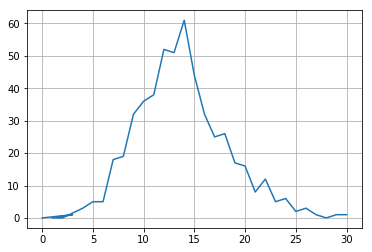

In [71]:
circle_counts = data_diameters.circle.value_counts()
circle_distribution = circle_counts.copy()
for i in range(len(circle_distribution)-1,-1,-1):
    if i not in circle_max_pdf.keys():
        continue
    for j in range(i-1, -1, -1):
        circle_distribution[j] -= circle_distribution[i]
circle_distribution
%matplotlib inline
plt.grid()
plt.plot(circle_distribution)

# 可以做一个条形图

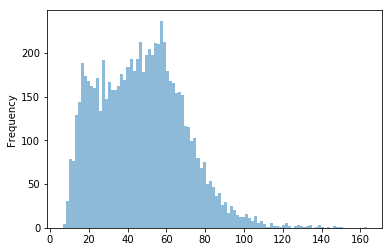

In [79]:
# 数密度分布图
diameter_counts = data_diameters[0]
plt.figure()
diameter_counts.plot.hist(bins=100,alpha=0.5)

### 统计破碎频率函数

In [62]:
pd.DataFrame({'a':[1,2],'b':[[1,1],[2,3,4]]})

,a,b
0,1,"[1, 1]"
1,2,"[2, 3, 4]"


In [ ]:


def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

##################################################
# Define a triangle by clicking three points
##################################################
plt.clf()
plt.axis([-1., 1., -1., 1.])
plt.setp(plt.gca(), autoscale_on=False)

tellme('You will define a triangle, click to begin')

plt.waitforbuttonpress()

happy = False
while not happy:
    pts = []
    while len(pts) < 3:
        tellme('Select 3 corners with mouse')
        pts = np.asarray(plt.ginput(3, timeout=-1))
        if len(pts) < 3:
            tellme('Too few points, starting over')
            time.sleep(1)  # Wait a second

    ph = plt.fill(pts[:, 0], pts[:, 1], 'r', lw=2)

    tellme('Happy? Key click for yes, mouse click for no')

    happy = plt.waitforbuttonpress()

    # Get rid of fill
    if not happy:
        for p in ph:
            p.remove()

##################################################
# Now contour according to distance from triangle
# corners - just an example
##################################################


# Define a nice function of distance from individual pts
def f(x, y, pts):
    z = np.zeros_like(x)
    for p in pts:
        z = z + 1/(np.sqrt((x - p[0])**2 + (y - p[1])**2))
    return 1/z

X, Y = np.meshgrid(np.linspace(-1, 1, 51), np.linspace(-1, 1, 51))
Z = f(X, Y, pts)

CS = plt.contour(X, Y, Z, 20)

tellme('Use mouse to select contour label locations, middle button to finish')
CL = plt.clabel(CS, manual=True)

##################################################
# Now do a zoom
##################################################
tellme('Now do a nested zoom, click to begin')
plt.waitforbuttonpress()

happy = False
while not happy:
    tellme('Select two corners of zoom, middle mouse button to finish')
    pts = np.asarray(plt.ginput(2, timeout=-1))

    happy = len(pts) < 2
    if happy:
        break

    pts = np.sort(pts, axis=0)
    plt.axis(pts.T.ravel())

tellme('All Done!')
plt.show()

You will define a triangle, click to begin
Select 3 corners with mouse
Happy? Key click for yes, mouse click for no
Use mouse to select contour label locations, middle button to finish
Select label locations manually using first mouse button.
End manual selection with second mouse button.
Now do a nested zoom, click to begin
Select two corners of zoom, middle mouse button to finish
Select two corners of zoom, middle mouse button to finish
Select two corners of zoom, middle mouse button to finish
Select two corners of zoom, middle mouse button to finish
All Done!
